# Load the Dataset

C:\Users\rinal\AppData\Local\Temp\ipykernel_17444\3332995301.py:15: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_dataset.csv',sep=',',encoding='iso-8859-1')


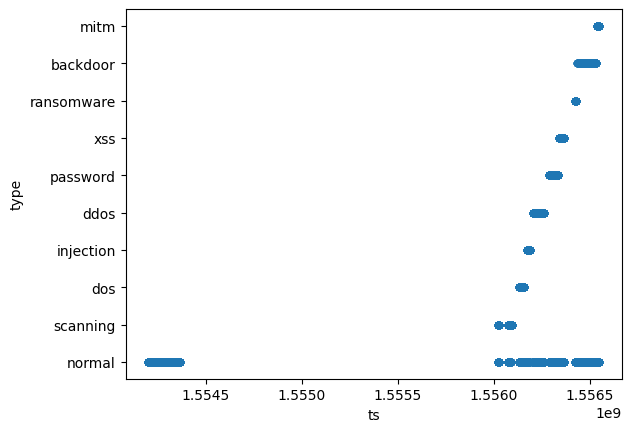

In [1]:
import pandas as pd
#encode categorical and numerical columns with label and ordinal encoding
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import numpy as np
#do random forest classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA

seed=4
					
# Load the dataset
df = pd.read_csv('train_dataset.csv',sep=',',encoding='iso-8859-1')

df.drop(columns=['label'], inplace=True)

#do a scatter plot of the data
df.plot.scatter(x='ts', y='type')
plt.show()

# Handling Null Values


In [2]:

#filter numerical columns
num_columns = df.select_dtypes(include=[np.number]).columns.tolist()
#filter categorical columns
cat_columns = df.select_dtypes(include=[object]).columns.tolist()

#replace '-' values in n columns with the mean of the column(both int and float columns)
for column in num_columns:
    df[column] = df[column].replace('-', df[column].mean())

#replace '-' values in categorical columns with the mode of the column
for column in cat_columns:
    df[column] = df[column].replace('-', df[column].mode().iloc[0])

#check for missing values
print(df.isnull().sum())

#check for nan values
print(df.isna().sum())
    
#encode categorical columns with label encoding
le = LabelEncoder()
df[cat_columns] = df[cat_columns].astype(str).apply(le.fit_transform)

# Encode numerical columns with ordinal encoding
oe = OrdinalEncoder()
df[num_columns] = oe.fit_transform(df[num_columns])





ts                        0
src_ip                    0
src_port                  0
dst_ip                    0
dst_port                  0
proto                     0
service                   0
duration                  0
src_bytes                 0
dst_bytes                 0
conn_state                0
missed_bytes              0
src_pkts                  0
src_ip_bytes              0
dst_pkts                  0
dst_ip_bytes              0
dns_query                 0
dns_qclass                0
dns_qtype                 0
dns_rcode                 0
dns_AA                    0
dns_RD                    0
dns_RA                    0
dns_rejected              0
ssl_version               0
ssl_cipher                0
ssl_resumed               0
ssl_established           0
ssl_subject               0
ssl_issuer                0
http_trans_depth          0
http_method               0
http_uri                  0
http_referrer             0
http_version              0
http_request_body_le

#  Data splitting + Variance Treshold Detector


In [3]:
#import train_test_split
from sklearn.model_selection import PredefinedSplit,train_test_split
#use variance treshold to select features
from sklearn.feature_selection import VarianceThreshold

X = df.drop(columns=['type'],axis=1)
y = df['type']

print("before variance treshold: ", X.shape)
selector = VarianceThreshold(0.01)
X = selector.fit_transform(X)
print("after variance treshold: ", X.shape)

indices = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indices, test_size=0.1, stratify=y, random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1

ps = PredefinedSplit(fold)
ps.get_n_splits()

X_val = X[val_idx, :]
y_val = y.iloc[val_idx]
X_train = X[train_idx, :]
y_train = y.iloc[train_idx]


before variance treshold:  (617002, 44)
after variance treshold:  (617002, 28)


# Preprocessing

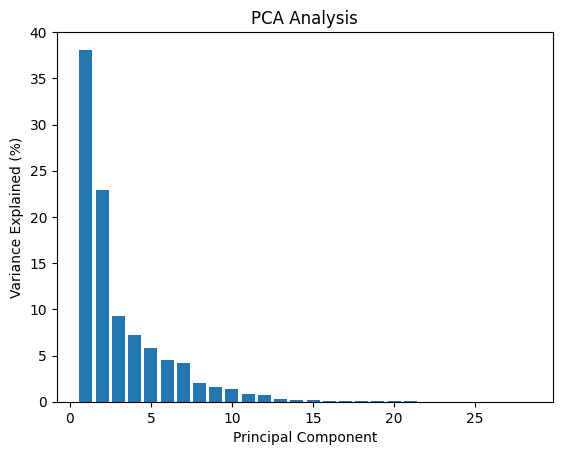

train:  (555301, 28)
validation: (61701, 28)


In [4]:
#do minmax scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X = scaler.transform(X)
X_val = scaler.transform(X_val)


#apply PCA
pca = PCA()
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)

#plot variance ratio in % for each principal component
explained_variance = pca.explained_variance_ratio_
explained_variance = np.round(explained_variance*100, decimals=1)

plt.bar(range(1,len(explained_variance)+1),explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('PCA Analysis')
plt.show()

#SHAPE OF TRAINING AND VALIDATION SETS
print("train: ", X_train.shape)
print("validation:", X_val.shape)



# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pickle

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ["linear", "poly", "rbf", "sigmoid"]}  

#get number of folds
ps.get_n_splits()


grid = GridSearchCV(SVC(random_state=seed), param_grid, cv=ps,verbose=10)
grid.fit(X, y)
file = open("svc.save","wb")
pickle.dump(grid.best_estimator_, file)
print("Best hyperparameters: ",grid.best_estimator_)
print("Best performance:",  grid.best_score_)
file.close()

y_pred = grid.predict(X_val)

#plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
disp.plot()
plt.show()




Fitting 1 folds for each of 100 candidates, totalling 100 fits
[CV 1/1; 1/100] START C=0.1, gamma=1, kernel=linear.............................


# Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
#train random forest classifier with hp tuning through grid search
param_grid = {'n_estimators': [100, 200, 300],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'criterion' :['gini', 'entropy']}

grid = GridSearchCV(RandomForestClassifier(random_state=seed), param_grid, cv=ps,verbose=10)

grid.fit(X, y)
print("Best hyperparameters: ",grid.best_estimator_)
print("Best performance:",  grid.best_score_)

#train the model with the best hyperparameters
model = grid.best_estimator_
model.fit(X_train, y_train)

#predict the validation set
y_pred = model.predict(X_val)

#calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

#print balanced accuracy,f1 score
from sklearn.metrics import balanced_accuracy_score,f1_score
print("Balanced accuracy:",balanced_accuracy_score(y_val, y_pred))
print("F1 score:",f1_score(y_val, y_pred,average='weighted'))


#plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)

disp.plot()
plt.show()

Fitting 1 folds for each of 90 candidates, totalling 90 fits
[CV 1/1; 1/90] START criterion=gini, max_depth=4, max_features=auto, n_estimators=100
[CV 1/1; 1/90] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 1/1; 2/90] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200
[CV 1/1; 2/90] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=nan total time=   0.0s
[CV 1/1; 3/90] START criterion=gini, max_depth=4, max_features=auto, n_estimators=300
[CV 1/1; 3/90] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=nan total time=   0.0s
[CV 1/1; 4/90] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100
[CV 1/1; 4/90] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100;, score=0.946 total time=  20.5s
[CV 1/1; 5/90] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200
[CV 1/1; 5/90] END criterion=gini, max_depth=4,

# KNN

In [1]:
#do the same with knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import pickle
param_grid = {'n_neighbors': [3, 5, 7, 9, 11],
              'metric': ['euclidean', 'manhattan'],
              'weights': ['uniform', 'distance'],}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=ps,verbose=10)


grid.fit(X, y)
#save the best model
print("Best hyperparameters: ",grid.best_estimator_)
print("Best performance:",  grid.best_score_)

#save the model with the best hyperparameters
file = open("knn.save","wb")
pickle.dump(grid.best_estimator_, file)
file.close()

y_pred = grid.predict(X_val)

#calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

#print balanced accuracy,f1 score
from sklearn.metrics import balanced_accuracy_score,f1_score
print("Balanced accuracy:",balanced_accuracy_score(y_val, y_pred))
print("F1 score:",f1_score(y_val, y_pred,average='weighted'))


#plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
disp.plot()
plt.show()


NameError: name 'ps' is not defined